# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import pickle

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function, generate_init


from agent import Person

from model import VirusModel, VirusModel_baseline




## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [3]:
# values = plt.hist(np.random.beta(1.5, 5, 10000),

#                   bins=200, density=True)

# plt.show()

In [4]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(5, 3, 10000),

#                   bins=200, density=True)

# plt.show()

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [5]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': ap.IntRange(0.25,0.3), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
results_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']



Scheduled runs: 20
0.6065
Completed: 1, estimated time remaining: 0:03:370.585
Completed: 2, estimated time remaining: 0:03:240.576
Completed: 3, estimated time remaining: 0:03:190.5915
Completed: 4, estimated time remaining: 0:03:090.5695
Completed: 5, estimated time remaining: 0:02:590.606
Completed: 6, estimated time remaining: 0:02:480.5875
Completed: 7, estimated time remaining: 0:02:350.5645
Completed: 8, estimated time remaining: 0:02:220.5975
Completed: 9, estimated time remaining: 0:02:090.607
Completed: 10, estimated time remaining: 0:01:570.5785
Completed: 11, estimated time remaining: 0:01:460.587
Completed: 12, estimated time remaining: 0:01:34

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6145
Completed: 13, estimated time remaining: 0:01:230.578
Completed: 14, estimated time remaining: 0:01:110.57
Completed: 15, estimated time remaining: 0:00:590.596
Completed: 16, estimated time remaining: 0:00:470.606
Completed: 17, estimated time remaining: 0:00:350.6
Completed: 18, estimated time remaining: 0:00:230.594
Completed: 19, estimated time remaining: 0:00:110.6005
Completed: 20, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:03:57.663343


In [6]:
df_baseline['misclassifications'] = (df_baseline['fraud'] - df_baseline['fraud_pred'])
df_baseline[df_baseline['fraud_pred'] ==0]['wealth'].min()

df_baseline.head()
df_baseline = df_baseline[df_baseline.fraud_pred != -1]
df_baseline

wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                           
0         1      1    0.286444           0      0     0       0          0   
                 2    0.294649           0      1     0       0          0   
                 3    0.303330           0      0     0       0          0   
                 4    0.312531           0      1     0       0          0   
                 5    0.322299           0      1     0       0          0   
...                        ...         ...    ...   ...     ...        ...   
19        500    96   1.000000           0      0     0       0          0   
                 97   1.000000           0      1     0       0          0   
                 98   1.000000           0      1     0       0          0   
                 99   1.000000           0      0     0       0          0   
                 100  1.000000           0      0     0       0          0   

                      misclassifications  
iteration obj_id t                        
0         1      1                     0  
                 2                     1  
                 3                     0  
                 4                     1  
                 5                     1  
...                                  ...  
19        500    96                    0  
                 97                    1  
                 98                    1  
                 99                    0  
                 100                   0  

[1000000 rows x 7 columns]

In [7]:
def viz2(data, x, y):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    # plt.xlim(0,50)

    plt.show()

In [8]:
def viz(data, x, y, hue, title = None):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    # plt.xlim(0,50)
    plt.title(title)

    plt.show()

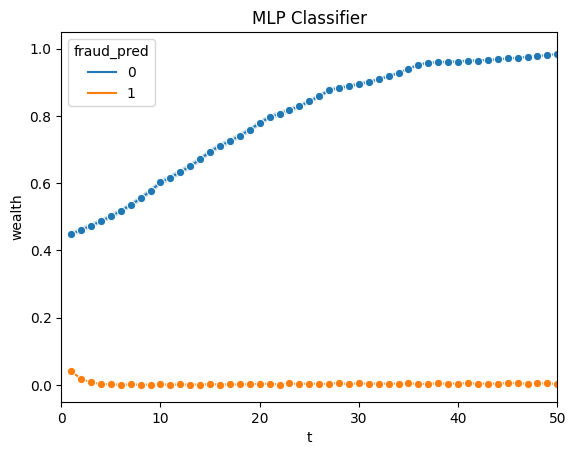

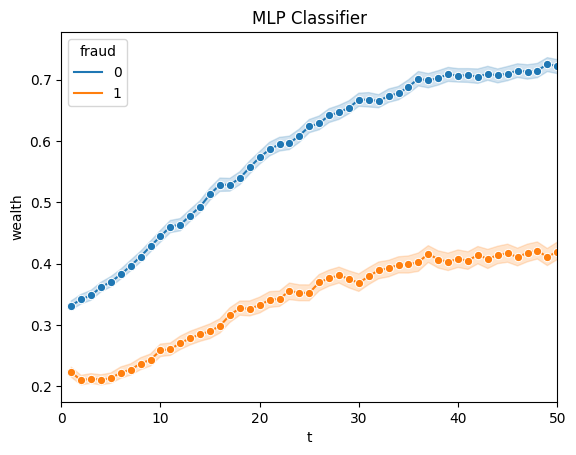

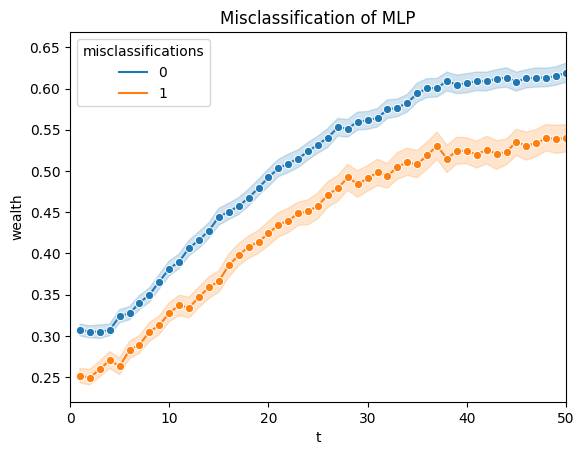

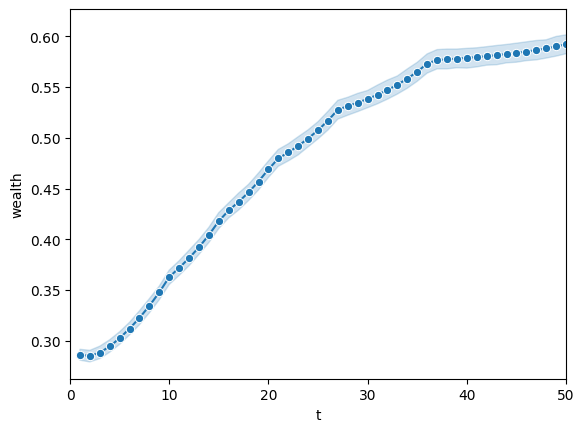

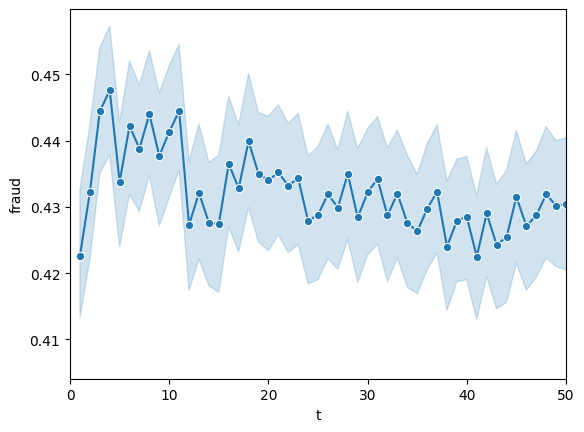

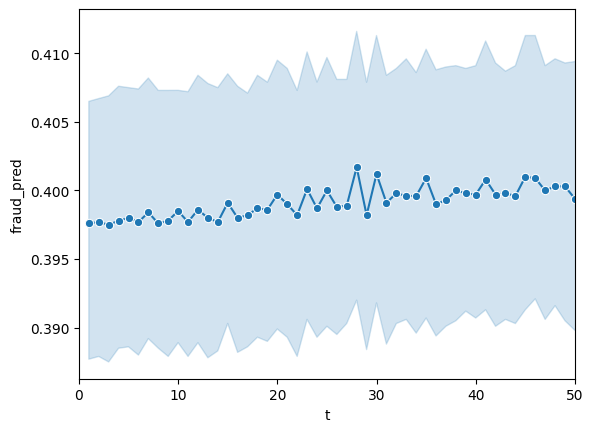

In [46]:
viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud_pred'], title= 'MLP Classifier') #, df_baseline['convicted'])

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud'], title = 'MLP Classifier') #, df_baseline['convicted'])

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], abs(df_baseline['misclassifications']), title= 'Misclassification of MLP') #, df_baseline['convicted'])

viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'])
viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['fraud'])
viz2(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['fraud_pred'])





# fig, ax = plt.subplots()

# sns.violinplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'], cut = True)

# # plt.ylim(0,0.2)
# plt.xlim(30, 60)
# # plt.title(title)

# plt.show()

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

In [ ]:

# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'],
#                 hue =df_baseline['fraud_pred'],
#                 marker = 'o' )

# sns.lineplot(ax = ax,
#                 data = df_baseline,
#                 x = df_baseline.index.get_level_values('t'),
#                 y = df_baseline['wealth'],
#                 hue =df_baseline['fraud'],
#                 marker = 'x' )

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# plt.title('title')

In [18]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0
df_baseline.head(400)
baseline1
# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




# df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
# df_wb0 = df_x0['wealth'] - baseline0['wealth']
# df_x0['wealth'] = df_wb0

# df_xb = pd.concat([df_x0, df_x1])

# df_xb

,wealth,fraud_pred,fraud,race,gender,convicted,misclassifications
t,,,,,,,
1,0.040697,1.0,0.552817,0.253773,0.391097,1.0,-0.447183
2,0.017741,1.0,0.585366,0.253960,0.390998,1.0,-0.414634
3,0.007266,1.0,0.600252,0.253585,0.391195,1.0,-0.399748
4,0.002774,1.0,0.622675,0.254148,0.390900,1.0,-0.377325
5,0.001353,1.0,0.601508,0.254523,0.390704,1.0,-0.398492
...,...,...,...,...,...,...,...
96,0.004664,1.0,0.604047,0.258806,0.388459,1.0,-0.395953
97,0.005932,1.0,0.627490,0.261205,0.387201,1.0,-0.372510
98,0.003794,1.0,0.611361,0.257508,0.389139,1.0,-0.388639


In [19]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.6, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': None, # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
r_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_b = r_baseline['variables']['Person']


Scheduled runs: 20
Completed: 20, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:32.017198


In [20]:
df_b['misclassifications'] = (df_b['fraud'] - df_b['fraud_pred'])
df_b[df_b['fraud_pred'] ==0]['wealth'].min()

df_b.head()
df_b = df_b[df_b.fraud_pred != -1]
df_b

wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                           
0         1      1    0.543584           0      0     0       1          0   
                 2    0.573133           0      0     0       1          0   
                 3    0.542427           1      0     0       1          1   
                 4    0.571849           0      1     0       1          1   
                 5    0.541152           1      1     0       1          1   
...                        ...         ...    ...   ...     ...        ...   
19        500    96   0.000000           1      1     0       1          1   
                 97   0.000000           0      1     0       1          1   
                 98   0.000000           1      1     0       1          1   
                 99   0.000000           1      0     0       1          1   
                 100  0.000000           1      0     0       1          1   

                      misclassifications  
iteration obj_id t                        
0         1      1                     0  
                 2                     0  
                 3                    -1  
                 4                     1  
                 5                     0  
...                                  ...  
19        500    96                    0  
                 97                    1  
                 98                    0  
                 99                   -1  
                 100                  -1  

[1000000 rows x 7 columns]

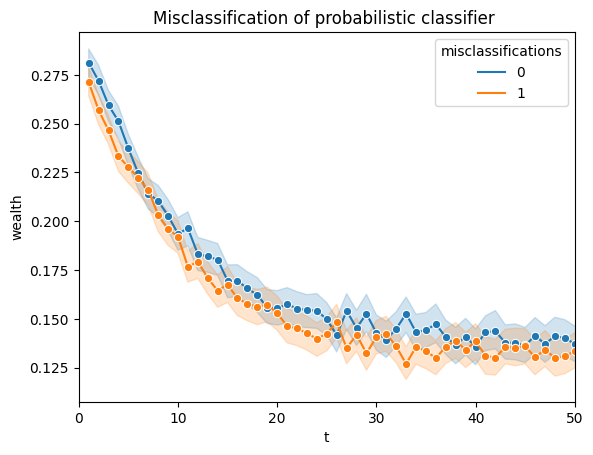

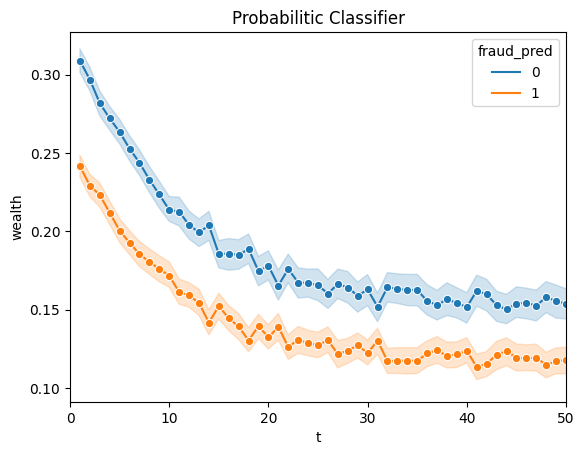

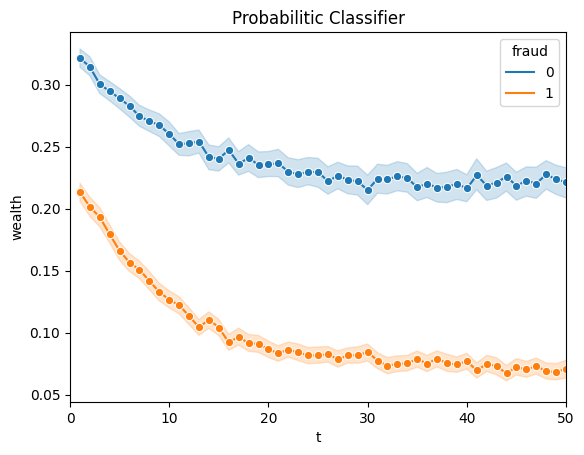

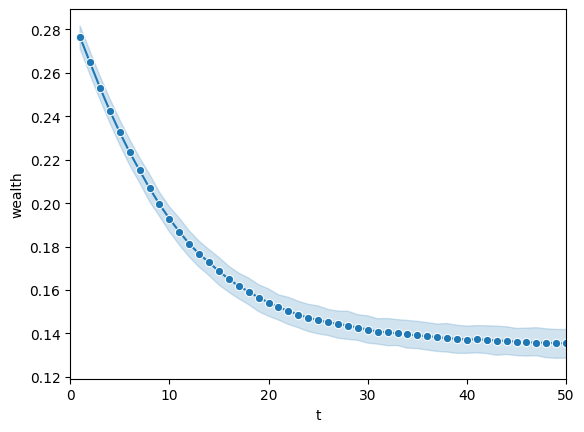

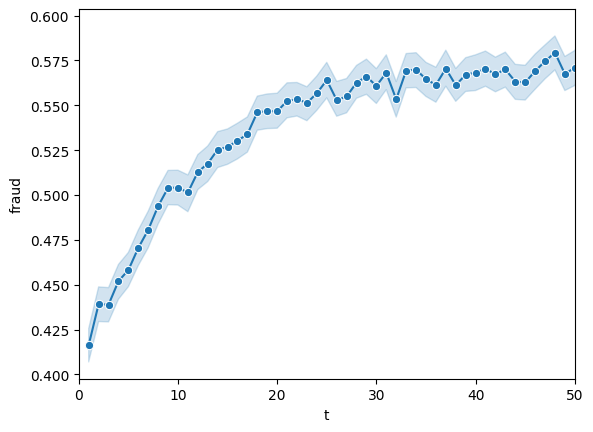

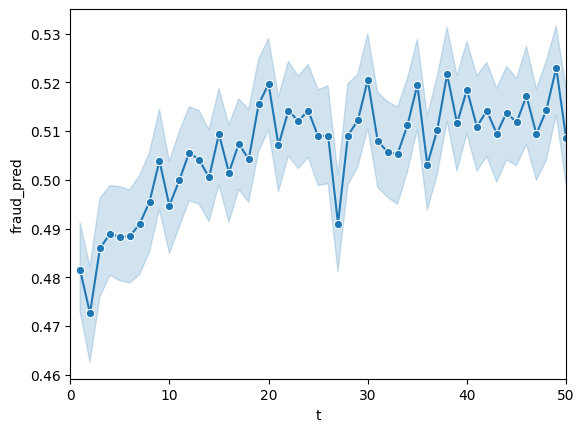

In [47]:
viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], abs(df_b['misclassifications']), title = 'Misclassification of probabilistic classifier ') #, df_baseline['convicted'])

viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud_pred'], title= 'Probabilitic Classifier') #, df_baseline['convicted'])

viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud'],title= 'Probabilitic Classifier') #, df_baseline['convicted'])

viz2(df_b, df_b.index.get_level_values('t'), df_b['wealth'])
viz2(df_b, df_b.index.get_level_values('t'), df_b['fraud'])
viz2(df_b, df_b.index.get_level_values('t'), df_b['fraud_pred'])
# fig, ax = plt.subplots()

# sns.violinplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'])

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# # plt.title(title)

# plt.show()
# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

NameError: name 'title' is not defined

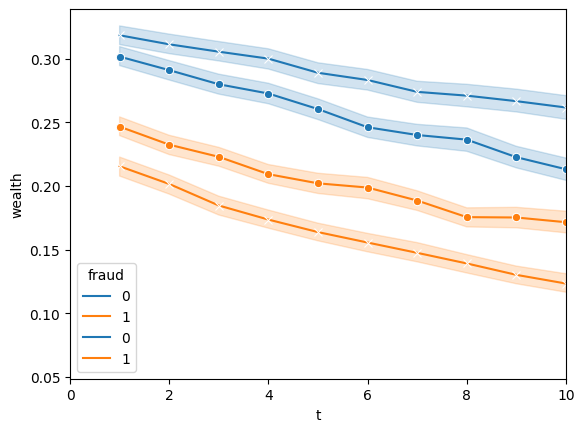

In [ ]:

# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'],
#                 hue =df_b['fraud_pred'],
#                 marker = 'o' )

# sns.lineplot(ax = ax,
#                 data = df_b,
#                 x = df_b.index.get_level_values('t'),
#                 y = df_b['wealth'],
#                 hue =df_b['fraud'],
#                 marker = 'x' )

# # plt.ylim(0,0.2)
# plt.xlim(0,10)
# plt.title('title')

# # viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud_pred']) #, df_baseline['convicted'])

# # viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud']) #, df_baseline['convicted'])